In [100]:
from qiskit import QuantumCircuit, Aer, assemble, transpile
import numpy as np
from fractions import Fraction
from math import pi
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

$\Large{\text{Quantum Period Finding}}$

We'll try to factorize N = 15. For this we'll use t counting bits such that $N^2 \leq 2^t \leq 2N^2 $ and $ n = log_2(n)$ bits to save the eigenstates of U. 



In [101]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [102]:
def inverse_qft(n):
    qc = QuantumCircuit(n)

    for i in range(n//2):
      qc.swap(i, n-1-i)
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/2**(j-m), m, j)
        qc.h(j)
    qc.name = "Inverse QFT"
    return qc

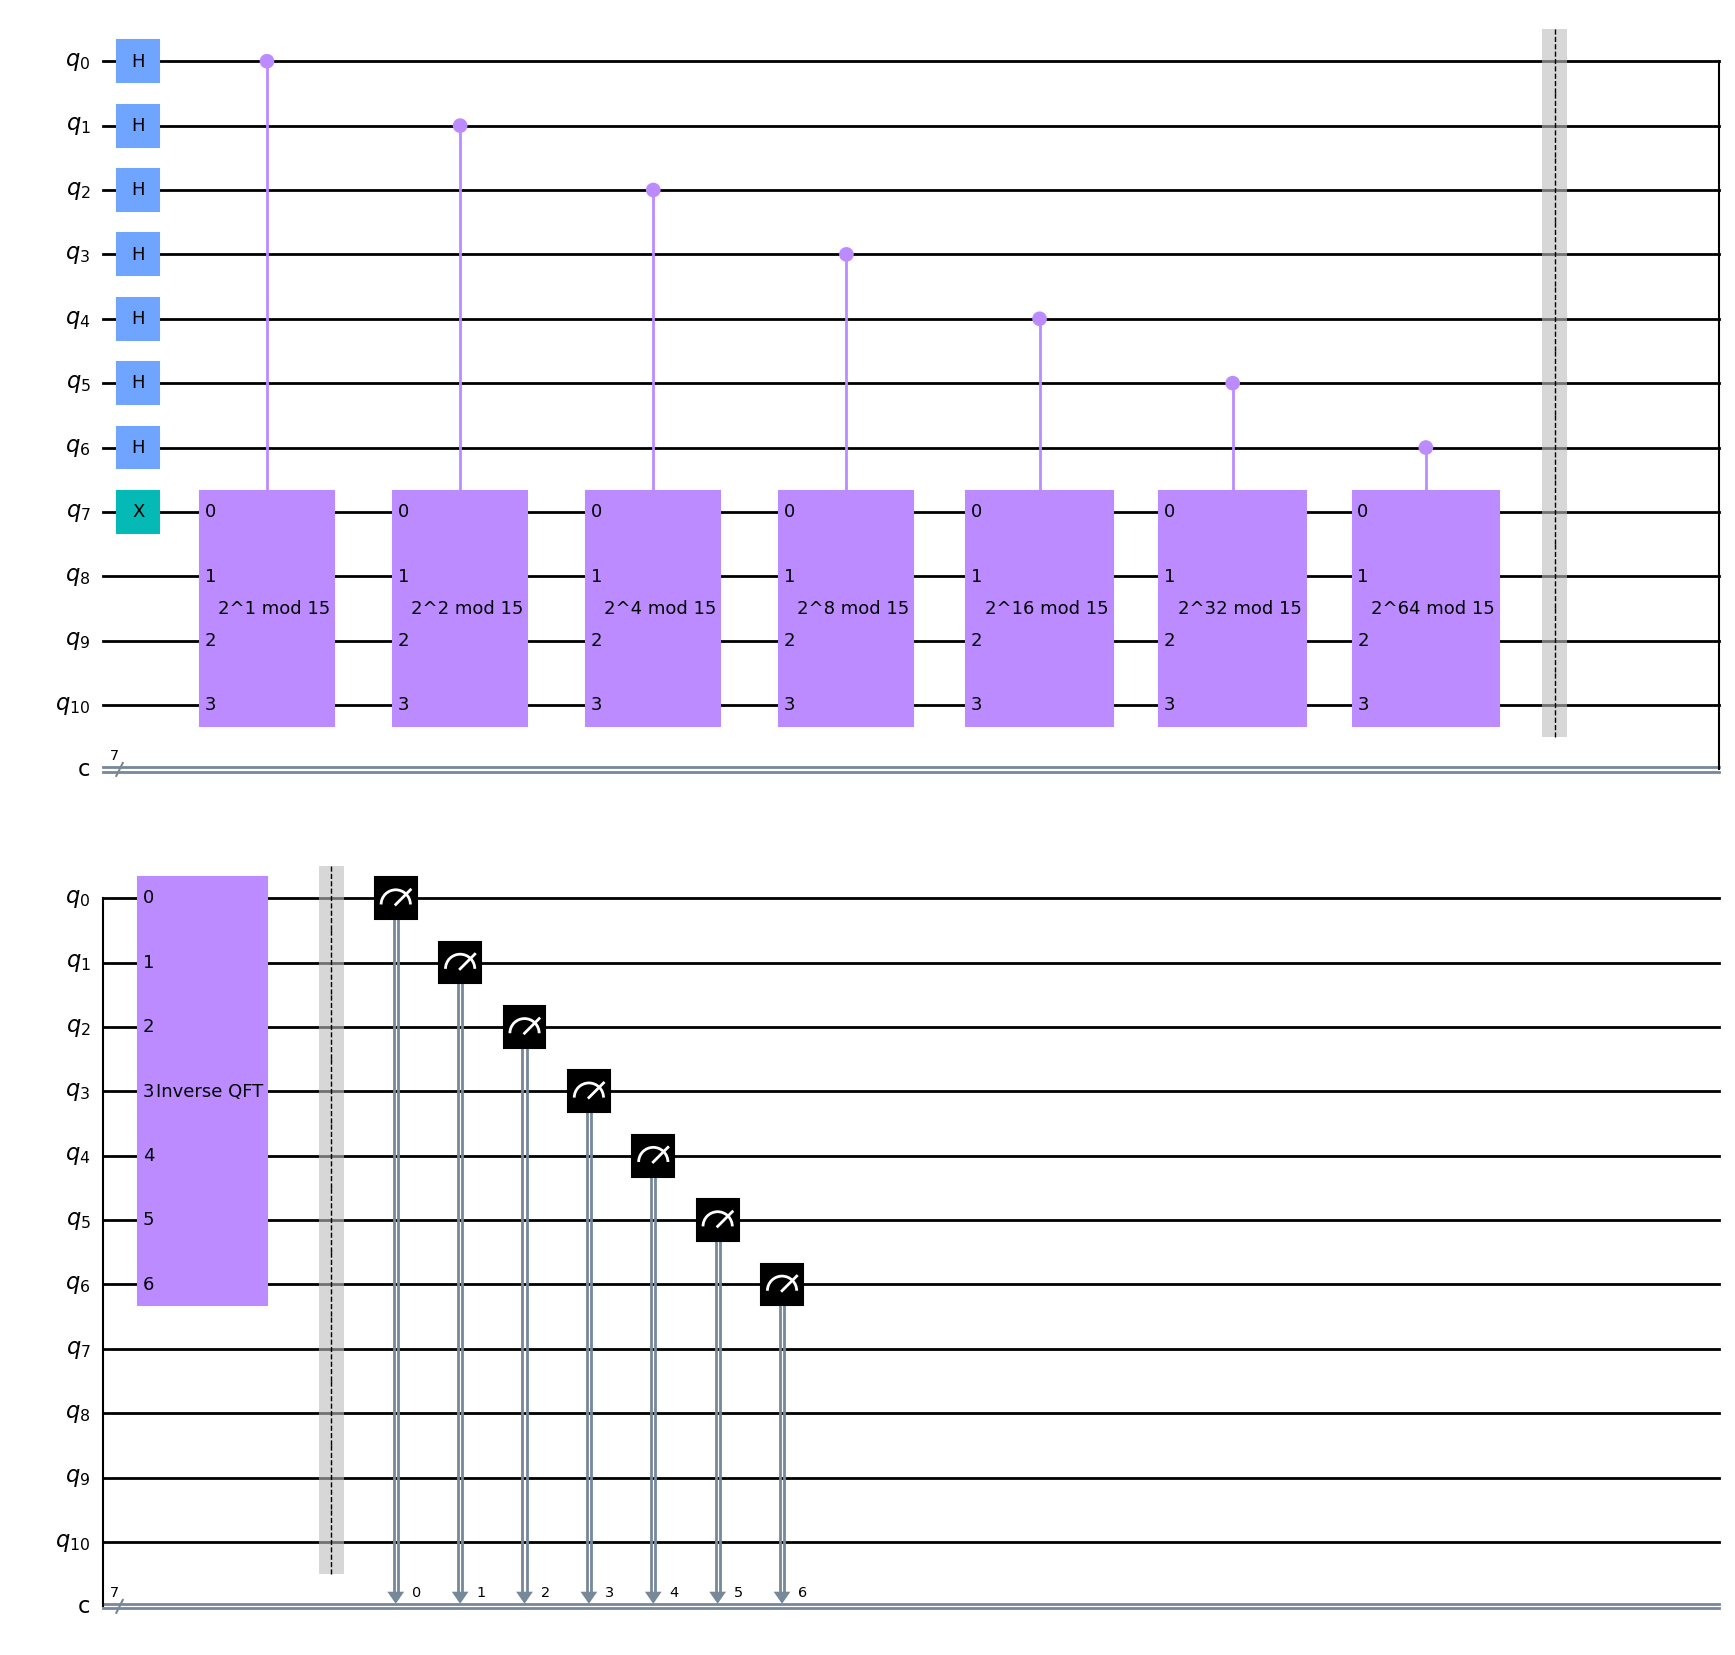

In [103]:
t = 7 #counting bits
n = 4
a = 2
N = 15

qc = QuantumCircuit(n+t, t)
for i in range(t):
    qc.h(i)
qc.x(t)

for j in range(t):
    qc.append(c_amod15(a, 2**j), [j] + [i + t for i in range(n)])
qc.barrier()
qc.append(inverse_qft(t), range(t))
qc.barrier()
for i in range(t):
    qc.measure(i, i)
qc.draw('mpl')

In [104]:
sim = Aer.get_backend('aer_simulator')
qc_t = transpile(qc, sim)
counts = sim.run(qc_t).result().get_counts()
print(counts)

{'1000000': 254, '0100000': 241, '0000000': 274, '1100000': 255}


In [105]:
phases = []
for u, v in counts.items():
    decimal = int(u, 2)
    phase = decimal/2**t
    phases.append(phase)
    print(f"{u} (binary) = {decimal} (Decimal) : Phase = {decimal}/{2**t}  = {phase}")

1000000 (binary) = 64 (Decimal) : Phase = 64/128  = 0.5
0100000 (binary) = 32 (Decimal) : Phase = 32/128  = 0.25
0000000 (binary) = 0 (Decimal) : Phase = 0/128  = 0.0
1100000 (binary) = 96 (Decimal) : Phase = 96/128  = 0.75


In [106]:
for i in phases:
    frac = Fraction(i).limit_denominator(N)
    print(f"Fraction: {frac.numerator}/{frac.denominator} , Guess for r:{frac.denominator}")

Fraction: 1/2 , Guess for r:2
Fraction: 1/4 , Guess for r:4
Fraction: 0/1 , Guess for r:1
Fraction: 3/4 , Guess for r:4


Factorization from period found

In [107]:
r = 4
def gcd(a, b):
    if (a%b == 0):
        return b
    else:
        return gcd(b , a%b)
    
if(gcd(a**(r/2) - 1, N)!=1 or gcd(a**(r/2) - 1, N)!= N):
    print("Non trivial factor : ", gcd(a**(r/2) - 1, N))


if(gcd(a**(r/2) + 1, N)!=1 or gcd(a**(r/2) + 1, N)!= N):
    print("Non trivial factor : ", gcd(a**(r/2) + 1, N))



Non trivial factor :  3.0
Non trivial factor :  5.0
